## Joint Sparsity With Partially Known Support - An illustrative example

This notebook helps the reader in understanding the benefits of partially known support in joint-sparse algorithms, described in the following paper:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import subspacemethods.music as music
import cs_algorithms.greedy.omp as omp
import cs_algorithms.greedy.iht as iht
import utils as ut

/home/abesson/anaconda3/envs/spl2018/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1. Problem of interest

We are interested in solving a joint-sparse recovery problem where we would like to retrieve a k-row sparse vector $\mathsf{X} \in \mathbb{K}^{n \times N}$ from linear measurements $\mathsf{Y} = \mathsf{A} \mathsf{A}$, where $\mathsf{X} \in \mathbb{K}^{m \times n}$.

We focus on the following combinatorial optimization problem, called the MMV problem (MMV is for multiple measurement vector):
$$\min \limits_{\mathsf{X} \in \mathbb{K}^{n \times N}} ||\mathsf{X}||_{0, row} \text{ subject to } \mathsf{Y} = \mathsf{A} \mathsf{X}$$

We introduce $\text{supp} \left(\mathsf{X}\right) = \cup_{i=1}^{N} \text{supp} \left( \mathbf{X}_i\right)$, such that $||\mathsf{X}||_{0, row} = |\text{supp} \left(\mathsf{X}\right)|$. We consider that $||\mathsf{X}||_{0, row} = k$ and we also assume that part of the support is known such that $\text{supp} \left(\mathsf{X}\right) = J_0 \cup J_1$, where $J_0$ is known.


### 2. The basics: Recovery guarantee in the general case
#### a. Recovery guarantee for the SMV problem
The SMV problem, where $N=1$, is very well-known in the literature, mostly with the emergence of compressed sensing. In such a case, a necessary and sufficient recovery confition for the unique recovery of the vector $\mathbf{x}$ from measurements $\mathbf{y} = \mathsf{A} \mathbf{x}$ is given by 
$$|\text{supp} \left(\mathbf{x}\right)| < \frac{\text{spark} \left(\mathsf{A}\right)}{2},$$ where $\text{spark} \left(\mathsf{A}\right)$ is the minimum number of linearly depdendent columns of $\mathsf{A}$.

Since $\text{spark} \left(\mathsf{A}\right) \leq m + 1$, we immediately have an upper-bound on the number of measurements $ m \geq 2k$.

Let's run a simple example!


Number of measurements: 30
Support recovery - IHT: True


/home/abesson/anaconda3/envs/spl2018/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


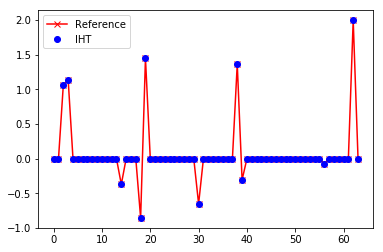

In [4]:
# General parameters of the simulation
n = 64
N = 16
k = 10
m = 30
print('Number of measurements: {}'.format(m))

# Seed number
prng = np.random.RandomState(seed=2)

# Generate Gaussian sensing matrix
stdev = 1 / np.sqrt(m)
A = ut.gaussian_matrix(m, n, mean=0, stdev=stdev, orthogonalize=True)

# Signal vector
x = np.random.randn(n, 1)
ind = np.random.permutation(n)
x[ind[:n-k]] = 0
supp_x = ind[n-k:]

# Measurements
y = np.matmul(A, x)

# CS signal recovery with orthogonal matching pursuit
iht_algo = iht.IHT(measurements=y, A=A, k=k, acceleration='normalized', verbose='NONE')
x_rec, supp_x_rec = iht_algo.solve()

# Support recovery
proba_recovery_smv = set(supp_x_rec) == set(supp_x)
print('Support recovery - IHT: {}'.format(proba_recovery_smv))

# Display the results
plt.figure()
plt.plot(x, color='red', marker='x', label='Reference')
plt.plot(x_rec, color='blue', marker='o', linestyle='None', label=iht_algo.name)
plt.legend()
plt.show()


#### b. Rank-aware recovery guarantee for the MMV problem
In the general case, when no partial support is known, Chen and Huo have established interesting theoretical guarantees for the MMV problem. In particular, they have demonstrated that a matrix $\mathsf{X}$ will be the unique solution of the MMV problem if 
$$|\text{supp} \left(\mathsf{X}\right)| < \frac{\text{spark} \left(\mathsf{A}\right) + \text{rank} \left(\mathsf{Y}\right) - 1}{2}.$$

Compared to the SMV problem, the MMV problem takes into account additional information contained in the measurement subspace $\mathcal{R} \left(\mathsf{Y}\right)$. Indeed, let us consider that that $\text{rank} \left( \mathsf{X} \right) = k$ (the non-zero rows of $\mathsf{X}$ are linearly independent). We introduce the set of indices of non-zero rows of $\mathsf{X}$ as $J \subset \left\lbrace 1, \ldots, n \right\rbrace$ and we also define $\mathsf{X}_{(J)}$ (resp $\mathsf{X}_{J}$) the restriction of $\mathsf{X}$ to the rows (resp. columns) indexed in $J$. Let us finally consider that $\text{spark} \left(\mathsf{A}\right) > k$.

It is clear that $\mathsf{Y} = \mathsf{A}_{J} \mathsf{X}_{\left( J\right)}$. Such a simple statement enlightens the relationship between $\text{rank} \left(\mathsf{Y}\right)$ and $|\text{supp} \left(\mathsf{X}\right)|$ since $\text{rank} \left(\mathsf{Y}\right) = k$. Thus, the dimension of $\mathcal{R} \left(\mathsf{Y}\right)$ is conditioned by the row-sparsity of $\mathsf{X}$.

We can even go further. Because of the above assumptions, we can notice that $\mathcal{R} \left(\mathsf{Y}\right) = \mathcal{R} \left(\mathsf{A}_{J}\right)$.
Thus, by identifying the columns of $\mathsf{A}$ that belong to $\mathcal{R} \left(\mathsf{Y}\right)$ one should be able to identify $\text{supp} \left(\mathsf{X}\right)$. This is the principle of subspace methods that have been developed in the context of MMV problems.

Let's draw a simple example to illustrate this!

In [5]:
# General parameters of the simulation
s = k
m = k+1
print('Number of measurements: {}'.format(m))

# Generate Gaussian sensing matrix
stdev = 1 / np.sqrt(m)
A = ut.gaussian_matrix(m, n, mean=0, stdev=stdev, orthogonalize=True)

# Signal matrix with full rank
X = np.random.randn(n, N)

# Mask the signal matrix to make it k-row sparse
row_supp = np.random.permutation(n)
row_supp = np.sort(row_supp[:k])
mask = np.zeros(shape=(n, 1))
mask[row_supp] = 1
X = mask * X

# Measurements
Y = np.matmul(A, X)

# MMV signal recovery with MUSIC
music_mmv = music.MUSIC(measurements=Y, A=A, k=k, rank=k)
X_rec, supp_X_rec = music_mmv.solve()

# Support recovery
proba_recovery_mmv = set(supp_X_rec) == set(row_supp)
print('Support recovery - MUSIC: {}'.format(proba_recovery_mmv))


Number of measurements: 11
******** MUSIC algorithm ********
Support recovery - MUSIC: True


### 3. Recovery guarantee with partially known support
#### a. Recovery guarantee for the SMV problem
The SMV problem with partially known support has been introduced by Vaswani and Lu under the acronym of 'modified-CS´. Their idea is to solve the minimization problem on the unknown part of the support. Formally, assume that $J_0$ is knwon, we are interested in the following problem:
$$\min \limits_{\mathbf{x} \in \mathbb{K}^{n}} ||\mathbf{x}_{(\bar{J_0})}||_{0} \text{ subject to } \mathbf{y} = \mathsf{A} \mathbf{x},$$
where $\bar{J_0}$ denotes the complement of $J_0$.

They also proved that the known support has a benefit in the recovery since it provides higher bound on the sparsity. A necessary and sufficient recovery confition for the unique recovery of the vector $\mathbf{x}$ from measurements $\mathbf{y} = \mathsf{A} \mathbf{x}$ is given by 
$$|\text{supp} \left(\mathbf{x}\right)| < \frac{\text{spark} \left(\mathsf{A}\right) + |J_0|}{2}$$ 

Since $\text{spark} \left(\mathsf{A}\right) \leq m + 1$, we immediately have an upper-bound on the number of measurements $ m \geq 2k - |J_0|$.

Let's run a simple example!



Number of measurements: 22
Support recovery - IHT: True


/home/abesson/anaconda3/envs/spl2018/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


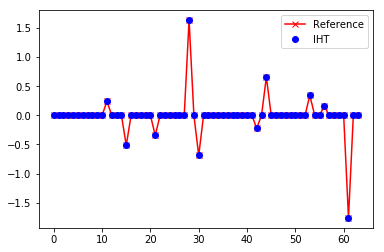

In [6]:
# General parameters of the simulation
m = 22
n_pks = 8
print('Number of measurements: {}'.format(m))

# Generate Gaussian sensing matrix
stdev = 1 / np.sqrt(m)
A = ut.gaussian_matrix(m, n, mean=0, stdev=stdev, orthogonalize=True)

# Signal vector
x = np.random.randn(n, 1)
ind = np.random.permutation(n)
x[ind[:n-k]] = 0
supp_x = ind[n-k:]

# Known support
pks = supp_x[:n_pks]

# Measurements
y = np.matmul(A, x)

# CS signal recovery with orthogonal matching pursuit
iht_algo = iht.IHT(measurements=y, A=A, k=k, acceleration='normalized', pks=pks, verbose='NONE')
x_rec, supp_x_rec = iht_algo.solve()

# Support recovery
proba_recovery_smv = set(supp_x_rec) == set(supp_x)
print('Support recovery - IHT: {}'.format(proba_recovery_smv))

# Display the results
plt.figure()
plt.plot(x, color='red', marker='x', label='Reference')
plt.plot(x_rec, color='blue', marker='o', linestyle='None', label=iht_algo.name)
plt.legend()
plt.show()



#### b. Rank-aware recovery guarantee for the MMV problem 
Here we come to the main result of this notebook. We have demonstrated that in case partial support is known, a sufficient condition for the unique recovery of $\mathsf{X}$ from $\mathsf{Y}$ is 

$$|\text{supp} \left(\mathsf{X}\right)| < \frac{\text{spark} \left(\mathsf{A}\right) + \text{rank} \left(\mathsf{Y}_a\right) - 1}{2},$$
where $\mathsf{Y}_a = [\mathsf{Y}, \mathsf{A}_{J_0}]$ is an augmented measurement matrix.

The intuition is rather clear. We use the partial support to augment the measurement subspace $\mathcal{R} \left(\mathsf{Y}\right)$ with vectors from $\mathcal{R} \left(\mathsf{A}_{J_0}\right)$. Thus, such a result is optimal when the rank of $\mathsf{X}_{(J_0)}$ is low while the columns of $\mathsf{A}_{J_0}$ are linearly independent in such a way that the effect of $\mathcal{R} \left(\mathsf{A}_{J_0}\right)$ on the measurements is maximized. 
Let's draw a simple example to illustrate this!

In [7]:
# Seed number
prng = np.random.RandomState(seed=2)

# General parameters of the simulation
n = 64
N = 128
k = 9
n_pks = 8
m = 19
print('Number of measurements: {}'.format(m))

# Generate Gaussian sensing matrix
stdev = 1 / np.sqrt(m)
A = ut.gaussian_matrix(m, n, mean=0, stdev=stdev, orthogonalize=True)

# Signal matrix with full rank
X = np.zeros(shape=(n, N))

# Known support
row_supp = np.random.permutation(n)
pks = row_supp[:n_pks]
X[pks] = 1

# Complement of the known support
J1 = row_supp[n_pks:k+n_pks]
X[J1] = np.random.randn(len(J1), N).copy()
supp_X = np.union1d(pks, J1).astype(int)

# Measurements
Y = np.matmul(A, X)

# MMV signal recovery with MUSIC
music_mmv = music.MUSIC(measurements=Y, A=A, k=len(J1)+len(pks), rank=len(J1)+1)
X_rec, supp_X_rec = music_mmv.solve()

# Support recovery
proba_recovery_mmv = set(supp_X_rec) == set(supp_X)
print('Support recovery - MUSIC: {}'.format(proba_recovery_mmv))

# MMV signal recovery with MUSIC
music_mmv = music.MUSIC(measurements=Y, A=A, k=len(J1)+len(pks), rank=len(J1)+1, pks=pks)
_, supp_X_rec_pks = music_mmv.solve()

# Support recovery
proba_recovery_mmv_pks = set(supp_X_rec_pks) == set(supp_X)
print('Support recovery - MUSIC - PKS: {}'.format(proba_recovery_mmv_pks))


Number of measurements: 19
******** MUSIC algorithm ********
Support recovery - MUSIC: False
******** MUSIC algorithm ********
Support recovery - MUSIC - PKS: True
